# Imports 

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import trapz
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

# Data exploration

## Train

In [3]:
train.shape

(188318, 132)

In [4]:
cat_features = [feature for feature in list(train) if 'cat' in feature]
print('{} categorical features'.format(len(cat_features)))

cont_features = [feature for feature in list(train) if 'cont' in feature]
print('{} of continuous features: '.format(len(cont_features)))

116 categorical features
14 of continuous features: 


In [5]:
assert len(cat_features) + len(cont_features) + 2 == train.shape[1]

### Categorical features 

How many categories do the categorical features have? 

In [6]:
cat_nr_dict = {}

for cat in cat_features:
    cat_nr_dict[cat] = train[cat].nunique()

In [7]:
cat_nr_series = pd.Series(cat_nr_dict)

In [8]:
cat_nr_series.value_counts().sort_index()

2      72
3       4
4      12
5       3
7       4
8       3
9       1
11      1
13      1
15      1
16      2
17      2
19      2
20      2
23      1
51      1
61      1
84      1
131     1
326     1
dtype: int64

In [9]:
for i in cat_nr_series.value_counts().sort_index()[-6:].index:
    
    perc = sum(train[cat_nr_series[cat_nr_series == i].index[0]].value_counts(normalize=1) < 0.01) / i

    print('Nr of categories: ', i)
    print('Perc of categories smaller than 1%: ', perc)
    print()

Nr of categories:  23
Perc of categories smaller than 1%:  0.521739130435

Nr of categories:  51
Perc of categories smaller than 1%:  0.588235294118

Nr of categories:  61
Perc of categories smaller than 1%:  0.573770491803

Nr of categories:  84
Perc of categories smaller than 1%:  0.952380952381

Nr of categories:  131
Perc of categories smaller than 1%:  0.862595419847

Nr of categories:  326
Perc of categories smaller than 1%:  0.923312883436



For some algorithms we need to create dummies from categorical variables, so we can cut off at categorgy being represented in $<1\%$ of the rows.

In [10]:
def to_other_cat(df, col, cut_off):
    df = df.copy()
    vc = df[col].value_counts(normalize=1)
    small_category = vc < cut_off
    small_category_list = list(small_category.index[small_category])
    small_category_filter = df[col].isin(small_category_list)
    df.loc[small_category_filter, col] = 'other'
    return df[col]

In [11]:
to_other_cat(train, 'cat116', 0.01).value_counts(normalize=1)

other    0.269353
HK       0.111837
DJ       0.107499
CK       0.053962
DP       0.048864
GS       0.046390
CR       0.036438
HX       0.029891
DC       0.024198
HG       0.023439
IE       0.022435
HQ       0.021474
HV       0.020460
GC       0.020195
LM       0.017401
LB       0.016961
LN       0.016605
KW       0.016382
HJ       0.014555
GK       0.013976
DF       0.013376
IG       0.012049
LO       0.011056
HB       0.010658
MD       0.010408
CB       0.010137
Name: cat116, dtype: float64

In [12]:
cut_off = 0.01

for feat in cat_features:
    train[feat + '_o'] = to_other_cat(train, feat, 0.01)
    
    # we need to ensure the same categories exist in the test set for when we make predictions
    test[feat + '_o'] = test[feat]
    
    keep_list = list(set(train[feat + '_o']))

    test.loc[~test[feat].isin(keep_list), feat + '_o'] = 'other'

In [13]:
cat_other_features = [feat for feat in list(train) if '_o' in feat]

In [14]:
cat_dummy_features = []

for feat in cat_other_features:
    train_dummy_df = pd.get_dummies(train[feat], prefix=feat, drop_first=True)
    
    dummy_features = list(train_dummy_df)
    
    train[dummy_features] = train_dummy_df
    
    cat_dummy_features = cat_dummy_features + dummy_features
    
    test_dummy_df = pd.get_dummies(test[feat], prefix=feat)
    
    test[dummy_features] = test_dummy_df[dummy_features]

In [15]:
assert set(list(test)) - set(list(train)) == set()

In [16]:
assert set(list(train)) - set(list(test)) == {'loss'}

The cat_dummy_features should all be boolean now

In [17]:
assert (train[cat_dummy_features].dtypes == 'uint8').all()

Random slice of the categoricals:

In [18]:
train[cat_dummy_features].sample(5).T.sample(5).T

,cat96_o_other,cat104_o_I,cat112_o_AI,cat41_o_B,cat65_o_B
52933,0,0,1,0,0
157264,0,0,0,0,0
51986,0,0,0,0,0
9941,0,0,0,0,0
122162,0,0,0,0,0


### Continuous features 

''

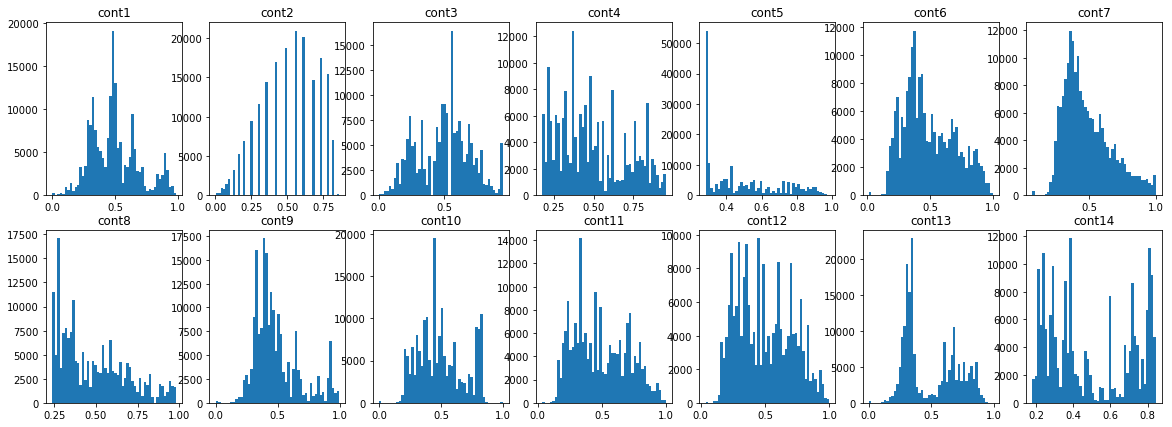

In [19]:
fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(20, 7))

k=0
for j in range(2):
    for i in range(7):
        ax[j,i].hist(train[cont_features[k]], bins=50)
        ax[j,i].set_title(cont_features[k])
        k+=1
;

Maybe cont2 can be changed to categorical variable.

In [20]:
c2_un = train['cont2'].nunique()
print('Cont2 has {} unique elements'.format(c2_un))

Cont2 has 33 unique elements


Hard to determine without context on what the variable represents, might be something like age in which case continuous makes sense. 

Let's look at features with correlation higher than 50%

In [21]:
cor = train[cont_features + ['loss']].corr()
cor[np.abs(cor)>0.5]

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
cont1,1.000000,NaN,NaN,NaN,NaN,0.758315,NaN,NaN,0.929912,0.808551,0.596090,0.614225,0.534850,NaN,NaN
cont2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont4,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,0.52874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont6,0.758315,NaN,NaN,NaN,NaN,1.000000,0.658918,NaN,0.797544,0.883351,0.773745,0.785144,0.815091,NaN,NaN
cont7,NaN,NaN,NaN,NaN,NaN,0.658918,1.000000,NaN,NaN,NaN,0.747108,0.742712,NaN,NaN,NaN
cont8,NaN,NaN,NaN,0.52874,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont9,0.929912,NaN,NaN,NaN,NaN,0.797544,NaN,NaN,1.000000,0.785697,0.608000,0.626656,0.642028,NaN,NaN
cont10,0.808551,NaN,NaN,NaN,NaN,0.883351,NaN,NaN,0.785697,1.000000,0.702896,0.713812,0.707876,NaN,NaN


There are some highly correlated features in there. 

### Target variable

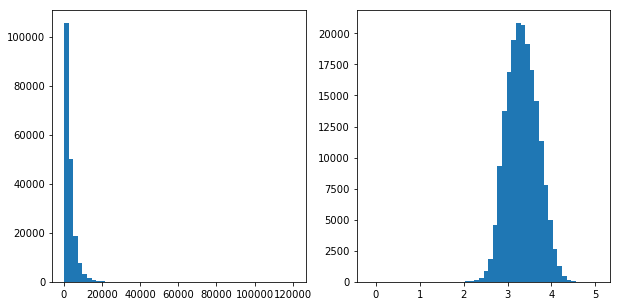

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].hist(train['loss'], bins=50);
ax[1].hist(np.log10(train['loss']), bins=50);

## Test +  sample submission

In [23]:
test.shape

(125546, 588)

In [24]:
sample_submission.shape

(125546, 2)

In [25]:
assert pd.Series(test['id'] == sample_submission['id']).all()

# Evaluation

Let's define a Lorenz curve 

In [26]:
l = [0,5,2,3]
print(np.argsort(l))

np.array(l)[np.argsort(l)]

[0 2 3 1]


array([0, 2, 3, 5])

In [27]:
np.array(l).cumsum()

array([ 0,  5,  7, 10])

In [28]:
def lorenz_curve(risk_proxy, loss):
    idx = np.argsort(risk_proxy)
    
    ordered_loss = loss[idx]
    cum_loss =  ordered_loss.cumsum() / sum(loss)
    x_axis = np.linspace(0,1,len(cum_loss))
    
    return x_axis, cum_loss

risk_proxy_example = np.array([1,2,4,6,4,2,1])
loss_example = np.array([0,1,0,3,4,0,0,])

lorenz_curve(risk_proxy_example, loss_example)

(array([ 0.        ,  0.16666667,  0.33333333,  0.5       ,  0.66666667,
         0.83333333,  1.        ]),
 array([ 0.   ,  0.   ,  0.125,  0.125,  0.125,  0.625,  1.   ]))

In [29]:
def score(x, y):
    integrate = trapz(x, y)
    
    return integrate

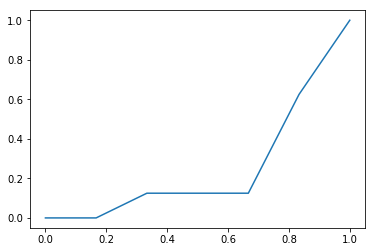

In [30]:
fig, ax = plt.subplots()

y = lorenz_curve(risk_proxy_example, loss_example)

ax.plot(y[0], y[1]);

In [31]:
score(y[0], y[1])

0.75

# RMSE 

# Process for modelling

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop('loss', axis=1),
    train[['loss']],
    test_size=0.33, 
    random_state=42
)

In [33]:
X_train.head(2)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cat116_o_HX,cat116_o_IE,cat116_o_IG,cat116_o_KW,cat116_o_LB,cat116_o_LM,cat116_o_LN,cat116_o_LO,cat116_o_MD,cat116_o_other
31228,98041,A,A,A,B,A,A,A,A,A,...,0,0,0,0,0,0,0,0,0,0
75562,236254,B,A,A,A,A,B,A,A,A,...,0,0,0,0,0,0,0,0,0,0


In [34]:
y_train.head(2)

,loss
31228,840.33
75562,1303.28


# GLM

In [40]:
assert X_train[cat_dummy_features + cont_features].notnull().all().all()

In [84]:
glm = smf.GLM(
    exog=sm.add_constant(X_train[cont_features]).astype(float).values,
    endog=y_train.astype(float).values,
    family=sm.families.Gamma(),
)

results_glm = glm.fit()

display(results_glm.summary2(xname=['const'] + list(X_train[cont_features])))

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
==================================================================
Model:              GLM              AIC:            2256545.6809 
Link Function:      inverse_power    BIC:            -1401931.0934
Dependent Variable: y                Log-Likelihood: -1.1283e+06  
Date:               2019-05-23 08:24 LL-Null:        -1.1312e+06  
No. Observations:   126173           Deviance:       79846.       
Df Model:           14               Pearson chi2:   9.43e+04     
Df Residuals:       126158           Scale:          0.74763      
Method:             IRLS                                          
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const      0.0005     0.0000    83.9685   0.0000    0.0005    0.0005
cont1      0.0002     0.0000    14.2305   0.0000    0.0002    0.0002
cont2     -0.0002     0.0000   -40.7400   0.0000   -0.0002   -0.0002
cont3      0.0000     0.0000     0.0685   0.9454   -0.0000    0.0000
cont4      0.0000     0.0000     7.4573   0.0000    0.0000    0.0001
cont5     -0.0000     0.0000    -2.1149   0.0344   -0.0000   -0.0000
cont6      0.0000     0.0000     2.3404   0.0193    0.0000    0.0001
cont7     -0.0001     0.0000   -16.4038   0.0000   -0.0002   -0.0001
cont8     -0.0000     0.0000    -6.4799   0.0000   -0.0000   -0.0000
cont9     -0.0002     0.0000   -13.6724   0.0000   -0.0002   -0.0002
cont10     0.0000     0.0000     2.2026   0.0276    0.0000    0.0000
cont11     0.0001     0.0000     3.3029   0.0010    0.0000    0.0002
cont12    -0.0002     0.0000    -5.7861   0.0000   -0.0003   -0.0001
cont13     0.0000     0.0000     5.0341   0.0000    0.0000    0.0001
cont14    -0.0000     0.0000    -7.8635   0.0000   -0.0000   -0.0000
==================================================================

"""

In [81]:
significant_features = []

for i in range(0, len(cat_features)):

    temp_dummy_feature_list = [dummy_cat for dummy_cat in cat_dummy_features if cat_features[i] + '_o' in dummy_cat]

    glm = smf.GLM(
        exog=sm.add_constant(X_train[temp_dummy_feature_list]).astype(float).values,
        endog=y_train.astype(float).values,
        family=sm.families.Gamma(),
    )

    results_glm = glm.fit()

    temp_res = results_glm.summary2(xname=['const'] + list(X_train[temp_dummy_feature_list]))

    temp_significance = temp_res.tables[1].loc[temp_dummy_feature_list, 'P>|z|']

    significant_features = significant_features + list(temp_significance[temp_significance < 0.05].index)

In [83]:
len(significant_features)

302

In [85]:
glm = smf.GLM(
    exog=sm.add_constant(X_train[significant_features]).astype(float).values,
    endog=y_train.astype(float).values,
    family=sm.families.Gamma(),
)

results_glm = glm.fit()

display(results_glm.summary2(xname=['const'] + list(X_train[significant_features])))

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
==================================================================
Model:              GLM              AIC:            2354094.9969 
Link Function:      inverse_power    BIC:            -1355894.3553
Dependent Variable: y                Log-Likelihood: -1.1768e+06  
Date:               2019-05-23 08:29 LL-Null:        -1.1329e+06  
No. Observations:   126173           Deviance:       1.2262e+05   
Df Model:           292              Pearson chi2:   5.81e+04     
Df Residuals:       125880           Scale:          0.46122      
Method:             IRLS                                          
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const              0.0005   0.0000  66.9157 0.0000  0.0005  0.0006
cat1_o_B           0.0001   0.0000  39.6900 0.0000  0.0001  0.0001
cat2_o_B          -0.0001   0.0000  -3.4802 0.0005 -0.0002 -0.0001
cat3_o_B           0.0000   0.0000   3.1052 0.0019  0.0000  0.0000
cat4_o_B          -0.0001   0.0000 -25.2299 0.0000 -0.0001 -0.0001
cat5_o_B          -0.0001   0.0000 -21.0744 0.0000 -0.0001 -0.0001
cat6_o_B          -0.0000   0.0000  -1.4878 0.1368 -0.0000  0.0000
cat7_o_B           0.0000   0.0000   7.7188 0.0000  0.0000  0.0000
cat8_o_B          -0.0000   0.0000  -9.4677 0.0000 -0.0000 -0.0000
cat9_o_B           0.0000   0.0000   2.5135 0.0120  0.0000  0.0001
cat10_o_B          0.0000   0.0000   0.6976 0.4854 -0.0000  0.0000
cat11_o_B          0.0000   0.0000   0.4396 0.6602 -0.0000  0.0000
cat12_o_B         -0.0000   0.0000  -2.2732 0.0230 -0.0001 -0.0000
cat13_o_B          0.0000   0.0000   1.0832 0.2787 -0.0000  0.0000
cat14_o_B          0.0001   0.0000   6.7394 0.0000  0.0001  0.0001
cat16_o_B         -0.0000   0.0000  -1.3325 0.1827 -0.0000  0.0000
cat17_o_other     -0.0000   0.0000  -2.3842 0.0171 -0.0000 -0.0000
cat18_o_other     -0.0000   0.0000  -3.5804 0.0003 -0.0000 -0.0000
cat19_o_other     -0.0000   0.0000  -6.7966 0.0000 -0.0001 -0.0000
cat20_o_other     -0.0000   0.0000  -5.2950 0.0000 -0.0001 -0.0000
cat21_o_other     -0.0000   0.0000  -0.4142 0.6787 -0.0000  0.0000
cat22_o_other     -0.0002   0.0000 -15.6734 0.0000 -0.0002 -0.0002
cat23_o_B          0.0000   0.0000   7.8136 0.0000  0.0000  0.0000
cat24_o_B          0.0000   0.0000  15.1493 0.0000  0.0000  0.0000
cat25_o_B         -0.0000   0.0000 -16.0168 0.0000 -0.0000 -0.0000
cat26_o_B         -0.0001   0.0000 -46.7821 0.0000 -0.0001 -0.0001
cat27_o_B         -0.0000   0.0000 -16.4633 0.0000 -0.0000 -0.0000
cat28_o_B          0.0000   0.0000   7.0536 0.0000  0.0000  0.0000
cat29_o_B         -0.0000   0.0000  -3.6237 0.0003 -0.0000 -0.0000
cat30_o_B         -0.0000   0.0000  -7.4699 0.0000 -0.0000 -0.0000
cat31_o_B          0.0000   0.0000   9.4809 0.0000  0.0000  0.0000
cat32_o_other     -0.0000   0.0000 -11.8288 0.0000 -0.0000 -0.0000
cat33_o_other      0.0001   0.0000  27.3775 0.0000  0.0001  0.0001
cat34_o_other      0.0000   0.0000   6.5143 0.0000  0.0000  0.0000
cat35_o_other     -0.0001   0.0000 -16.3915 0.0000 -0.0001 -0.0000
cat36_o_B         -0.0000   0.0000  -2.8085 0.0050 -0.0000 -0.0000
cat37_o_B         -0.0000   0.0000 -20.9987 0.0000 -0.0000 -0.0000
cat38_o_B         -0.0000   0.0000 -10.7717 0.0000 -0.0000 -0.0000
cat39_o_B          0.0000   0.0000   9.6891 0.0000  0.0000  0.0000
cat40_o_B          0.0000   0.0000  21.5657 0.0000  0.0000  0.0000
cat41_o_B          0.0000   0.0000   9.2624 0.0000  0.0000  0.0000
cat42_o_other     -0.0000   0.0000  -7.5409 0.0000 -0.0000 -0.0000
cat43_o_B          0.0000   0.0000   6.7200 0.0000  0.0000  0.0000
cat44_o_B         -0.0001   0.0000 -39.7440 0.0000 -0.0001 -0.0001
cat45_o_B          0.0000   0.0000   3.0658 0.0022  0.0000  0.0000
cat46_o_other      0.0000   0.0000   8.7273 0.0000  0.0000  0.0000
cat47_o_other  


# XGB

# Random Forest

# Ensemble

# Shap values

# Results 

# Kaggle 